**Assigment Number 2**

**Name:** Tejas Bawankar

**NU ID:** 001590464

##**Abstract-**

 assignment is based on H2O AutoML understanding and examine the results on Regression dataset.

Brief intro about dataset - 

The dataset contains the temprature and related columns which is required to predict the temprature values - 
The features/columns for this dataset are as follows -
1. Formatted Date
2. Summary
3. Precip Type
4. Temperature (C)
5. Apparent Temperature (C)
6. Humidity
7. Wind Speed (km/h)
8. Wind Bearing (degrees)
9. Visibility (km)
10. Loud Cover

Here in this assigment I will perform basic Data analysis, AutoML execution, find best Model and parameters, Performing regularization and hyperparameters tunning. I will also calculate p-values and colinearity between the columns of given dataset.

##**Importing Libraries and H2O initialization**

In [18]:
#importing all the necessary libraries
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import numpy as np
import scipy

In [19]:
#pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [20]:
# Set a minimum memory size and a run time in seconds
min_mem_size=6 
run_time=222

In [21]:
# Use 50% of availible resources
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

5


In [22]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:34212 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmppcf7aehj
  JVM stdout: /tmp/tmppcf7aehj/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmppcf7aehj/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:34212
Connecting to H2O server at http://127.0.0.1:34212 ... successful.


--------------------------  ----------------------------------------------------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.0.2
H2O_cluster_version_age:    19 days
H2O_cluster_name:           H2O_from_python_unknownUser_ucgqxx
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    5 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:34212
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, Infogram, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.12 final
--------------------------  ----------------------------------------------------------------------------

##**Data Analysis**

In [23]:
#Importing dataset
df1 = pd.read_csv("/content/drive/MyDrive/DSEM/weatherHistory.csv")

In [24]:
 df1 = df1.drop(['Summary', 'Daily_Summary', 'Precip_Type', 'Formatted_Date'], axis=1)

In [25]:
#finding out basic statistics of dataset
df1.describe()

Temperature  Apparent_Temperature  ...  Loud_Cover      Pressure
count  96453.000000          96453.000000  ...     96453.0  96453.000000
mean      11.932678             10.855029  ...         0.0   1003.235956
std        9.551546             10.696847  ...         0.0    116.969906
min      -21.822222            -27.716667  ...         0.0      0.000000
25%        4.688889              2.311111  ...         0.0   1011.900000
50%       12.000000             12.000000  ...         0.0   1016.450000
75%       18.838889             18.838889  ...         0.0   1021.090000
max       39.905556             39.344444  ...         0.0   1046.380000

[8 rows x 8 columns]

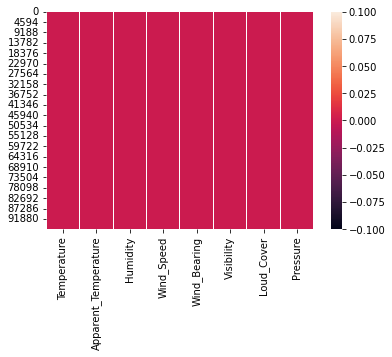

In [26]:
#graphical mapping of null values
sns.heatmap(df1.isnull())

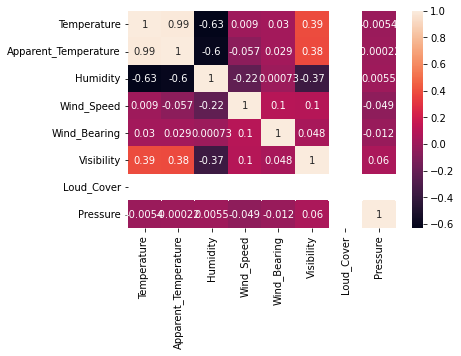

In [27]:
sns.heatmap(df1.corr(),annot= True)

In [28]:
df1.corr()

Temperature  Apparent_Temperature  ...  Loud_Cover  Pressure
Temperature              1.000000              0.992629  ...         NaN -0.005447
Apparent_Temperature     0.992629              1.000000  ...         NaN -0.000219
Humidity                -0.632255             -0.602571  ...         NaN  0.005454
Wind_Speed               0.008957             -0.056650  ...         NaN -0.049263
Wind_Bearing             0.029988              0.029031  ...         NaN -0.011651
Visibility               0.392847              0.381718  ...         NaN  0.059818
Loud_Cover                    NaN                   NaN  ...         NaN       NaN
Pressure                -0.005447             -0.000219  ...         NaN  1.000000

[8 rows x 8 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fead18b6610>,
      dtype=object)

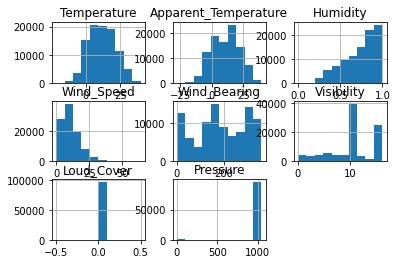

In [29]:
#histogram - distrubution of frequency
df1.hist()

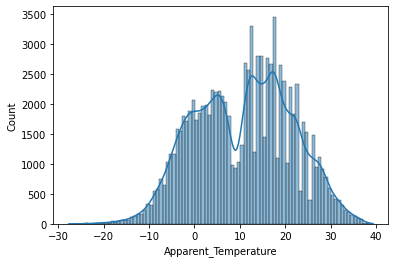

In [30]:
# to check bell curve for normal distrubution
sns.histplot(df1.Apparent_Temperature, kde = True)

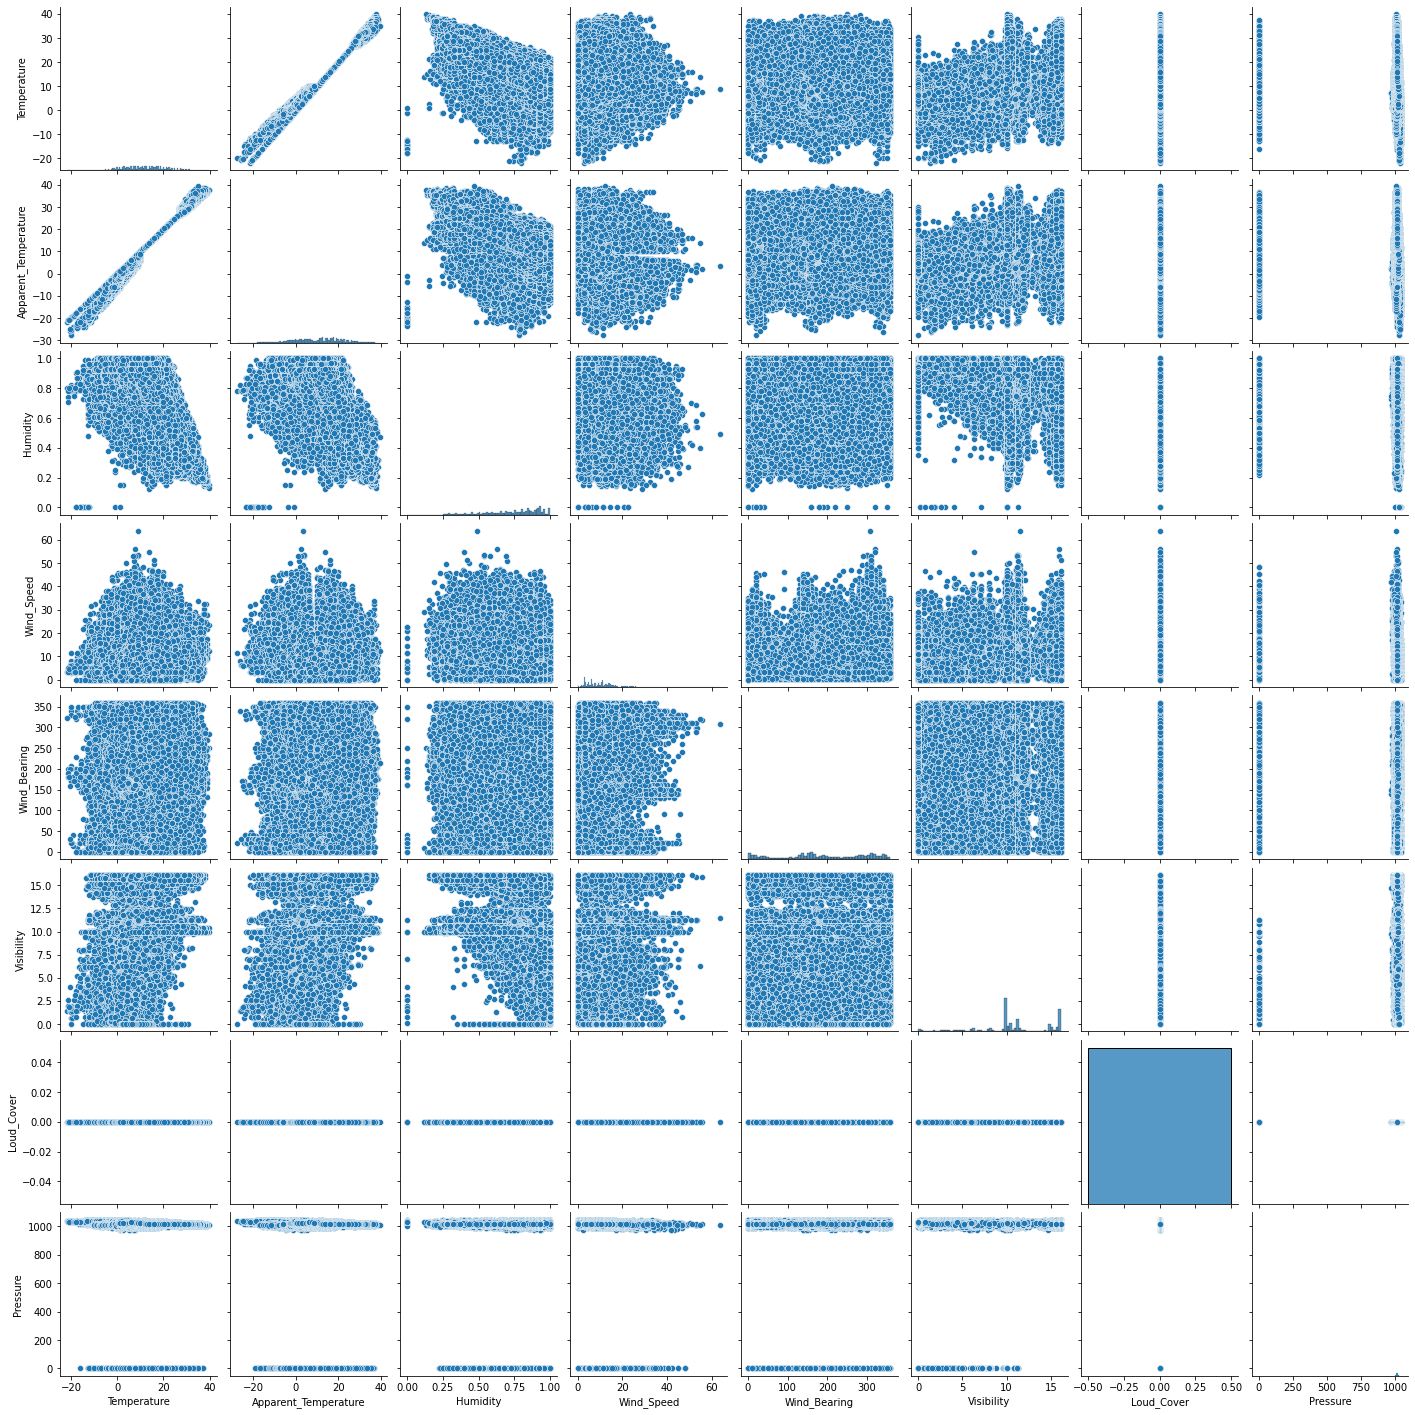

In [31]:
#getting an idea of relation between variables
sns.pairplot(df1)

##**H2O AutoML Execution**

In [32]:
# Create a 80/20 train/test split
url = "/content/drive/MyDrive/DSEM/weatherHistory.csv"
df = h2o.import_file(path = url)
pct_rows=0.80
df_train, df_test = df.split_frame([pct_rows])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [33]:
print(df_train.shape)
print(df_test.shape)

(77197, 12)
(19256, 12)


In [34]:
# Set the features and target
X=df.columns
print(X)

['Formatted_Date', 'Summary', 'Precip_Type', 'Temperature', 'Apparent_Temperature', 'Humidity', 'Wind_Speed', 'Wind_Bearing', 'Visibility', 'Loud_Cover', 'Pressure', 'Daily_Summary']


In [35]:
# Set target and predictor variables
y ='Apparent_Temperature'
X.remove(y) 
print(X)

['Formatted_Date', 'Summary', 'Precip_Type', 'Temperature', 'Humidity', 'Wind_Speed', 'Wind_Bearing', 'Visibility', 'Loud_Cover', 'Pressure', 'Daily_Summary']


In [36]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)

In [37]:
aml.train(x=X,y=y,training_frame=df_train)  

AutoML progress: |
01:41:06.156: _train param, Dropping bad and constant columns: [Formatted_Date, Loud_Cover]

███████████████████
01:42:11.227: _train param, Dropping bad and constant columns: [Formatted_Date, Loud_Cover]

███
01:42:24.239: _train param, Dropping bad and constant columns: [Formatted_Date, Loud_Cover]

██████████████████████████
01:43:56.320: _train param, Dropping unused columns: [Formatted_Date, Loud_Cover]

█
01:43:59.325: _train param, Dropping bad and constant columns: [Formatted_Date, Loud_Cover]

██
01:44:08.332: _train param, Dropping bad and constant columns: [Formatted_Date, Loud_Cover]

███
01:44:19.339: _train param, Dropping bad and constant columns: [Formatted_Date, Loud_Cover]

██
01:44:26.346: _train param, Dropping bad and constant columns: [Formatted_Date, Loud_Cover]

██
01:44:33.351: _train param, Dropping bad and constant columns: [Formatted_Date, Loud_Cover]

██
01:44:40.357: _train param, Dropping unused columns: [Formatted_Date, Loud_Cover]

█


number_of_trees  ...  max_leaves  mean_leaves
0              123.0  ...       472.0    344.30893

[1 rows x 10 columns]



ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.018355853942540346
RMSE: 0.13548377741464232
MAE: 0.07224063528022145
RMSLE: NaN
Mean Residual Deviance: 0.018355853942540346

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.03250968705227767
RMSE: 0.18030442882047482
MAE: 0.098955594704848
RMSLE: NaN
Mean Residual Deviance: 0.03250968705227767

Cross-Validation Metrics Summary: 


mean  ...  cv_4_valid  cv_5_valid
0                     mae  0.098955  ...    0.098124    0.092728
1  mean_residual_deviance  0.032510  ...    0.031407    0.028009
2                     mse  0.032510  ...    0.031407    0.028009
3                      r2  0.999716  ...    0.999725    0.999755
4       residual_deviance  0.032510  ...    0.031407    0.028009
5                    rmse  0.179957  ...    0.177220    0.167359
6                   rmsle       NaN  ...         NaN         NaN

[7 rows x 8 columns]


Scoring History: 


timestamp  ... training_mae  training_deviance
0     2022-02-14 01:43:41  ...     9.011469         114.489510
1     2022-02-14 01:43:42  ...     5.322381          40.080144
2     2022-02-14 01:43:43  ...     3.143240          14.130800
3     2022-02-14 01:43:43  ...     1.857309           4.972546
4     2022-02-14 01:43:44  ...     1.234236           2.171671
5     2022-02-14 01:43:44  ...     0.806914           0.954588
6     2022-02-14 01:43:45  ...     0.514143           0.411113
7     2022-02-14 01:43:45  ...     0.321760           0.177974
8     2022-02-14 01:43:46  ...     0.212160           0.089785
9     2022-02-14 01:43:46  ...     0.164506           0.061010
10    2022-02-14 01:43:47  ...     0.127380           0.042556
11    2022-02-14 01:43:47  ...     0.109337           0.034507
12    2022-02-14 01:43:48  ...     0.097126           0.029554
13    2022-02-14 01:43:48  ...     0.090957           0.026938
14    2022-02-14 01:43:49  ...     0.086791           0.025027
15    2022-02-14 01:43:50  ...     0.083296           0.023487
16    2022-02-14 01:43:50  ...     0.080573           0.022385
17    2022-02-14 01:43:51  ...     0.078823           0.021666
18    2022-02-14 01:43:51  ...     0.077607           0.021156
19    2022-02-14 01:43:52  ...     0.076347           0.020526

[20 rows x 7 columns]


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0    Temperature         3.888290e+07           1.000000    0.900535
1    Precip_Type         3.371540e+06           0.086710    0.078086
2     Wind_Speed         3.196696e+05           0.008221    0.007404
3       Humidity         2.444715e+05           0.006287    0.005662
4  Daily_Summary         2.088279e+05           0.005371    0.004836
5     Visibility         8.168159e+04           0.002101    0.001892
6       Pressure         3.941681e+04           0.001014    0.000913
7        Summary         1.988140e+04           0.000511    0.000460
8   Wind_Bearing         9.146339e+03           0.000235    0.000212

In [38]:
print(aml.leaderboard)

model_id mean_residual_deviance rmse mse mae rmsle 
 
 
 GBM_1_AutoML_1_20220214_14105 0.0325097 0.180304 0.0325097 0.0989556 nan 
 StackedEnsemble_BestOfFamily_2_AutoML_1_20220214_14105 0.0446174 0.211228 0.0446174 0.129781 nan 
 StackedEnsemble_AllModels_1_AutoML_1_20220214_14105 0.044657 0.211322 0.044657 0.130088 nan 
 StackedEnsemble_BestOfFamily_1_AutoML_1_20220214_14105 0.0456582 0.213678 0.0456582 0.141289 nan 
 DRF_1_AutoML_1_20220214_14105 0.62383 0.789829 0.62383 0.401787 nan 
 XGBoost_1_AutoML_1_20220214_14105 0.763183 0.873603 0.763183 0.62273 nan 
 GLM_1_AutoML_1_20220214_14105 1.09717 1.04746 1.09717 0.827485 nan 
 XGBoost_2_AutoML_1_20220214_14105 1.24052 1.11379 1.24052 0.833392 nan 
 GBM_2_AutoML_1_20220214_14105 6.92931 2.63236 6.92931 2.10592 nan 
 GBM_3_AutoML_1_20220214_14105 11.8968 3.44918 11.8968 2.77823 nan

In [39]:
#Understanding the leaderboard
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break 
  model_index=model_index+1  

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break  
  glm_index=glm_index+1     
models_dict

{'GBM_1_AutoML_1_20220214_14105': 0, 'GLM_1_AutoML_1_20220214_14105': 6}

In [40]:
#Examine the leaderboard
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])

0


In [41]:
best_model.algo

'gbm'

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

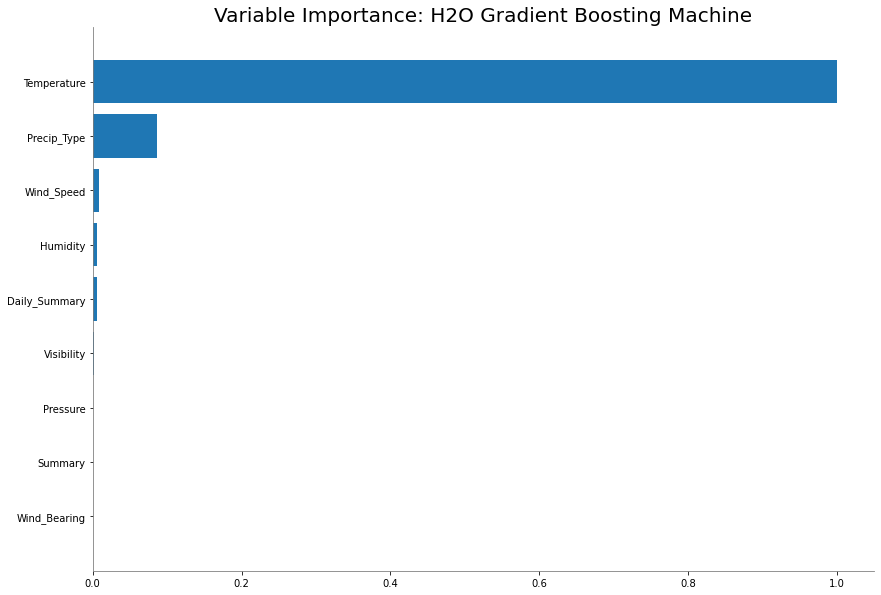

<Figure size 432x288 with 0 Axes>

In [43]:
if best_model.algo in ['gbm','drf','xrt','xgboost']:
  best_model.varimp_plot()

6
glm


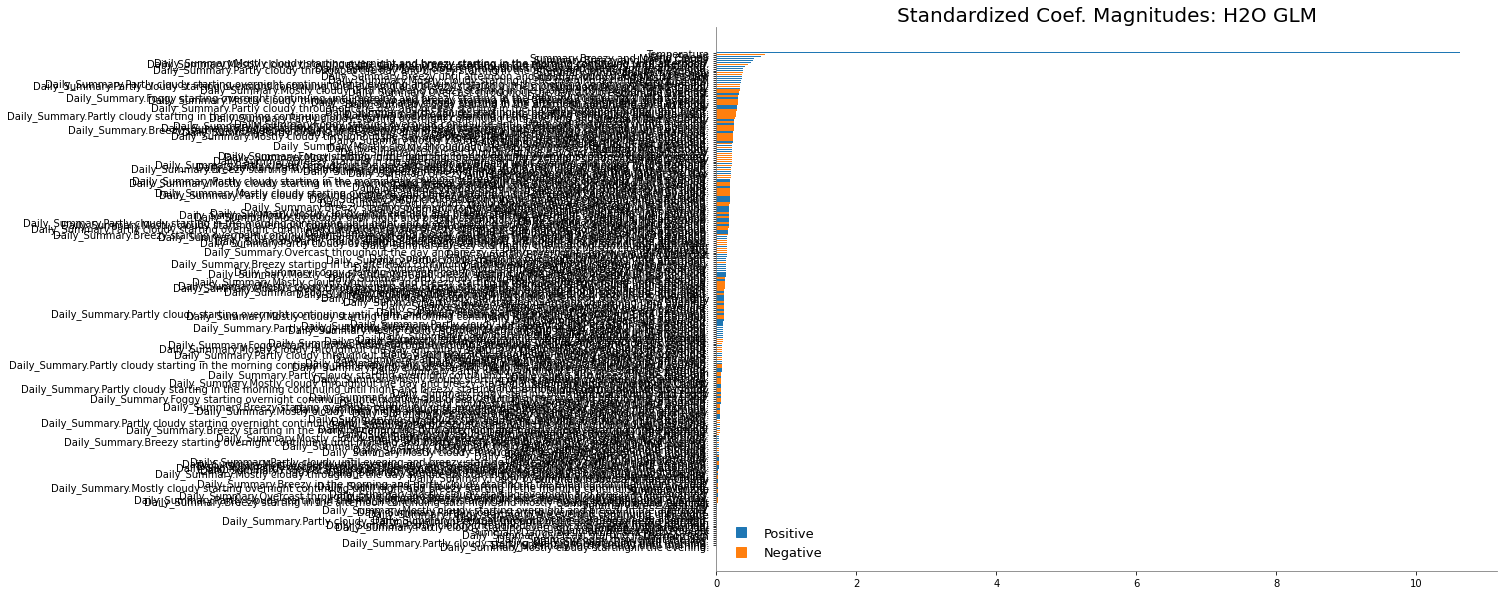

In [44]:
if glm_index is not 0:
  print(glm_index)
  glm_model=h2o.get_model(aml.leaderboard[glm_index,'model_id'])
  print(glm_model.algo) 
  glm_model.std_coef_plot()

In [45]:
print(best_model.rmse(train = True))

0.13548377741464232


In [46]:
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d

In [47]:
mod_perf=best_model.model_performance(df_test)
stats_test={}
stats_test=model_performance_stats(mod_perf)
stats_test

{'mse': 0.027666222518573653,
 'null_degrees_of_freedom': None,
 'null_deviance': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'rmse': 0.1663316642091146}

In [48]:
predictions = best_model.predict(df_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [49]:
y_pred=h2o.as_list(predictions)
y_pred[0:5]

predict
0   5.829373
1  13.866395
2  15.493539
3   7.614126
4  17.316548

In [50]:
#Partial Dependency Plots
print(X)

['Formatted_Date', 'Summary', 'Precip_Type', 'Temperature', 'Humidity', 'Wind_Speed', 'Wind_Bearing', 'Visibility', 'Loud_Cover', 'Pressure', 'Daily_Summary']


PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%

PartialDependence: Partial Dependence Plot of model GBM_1_AutoML_1_20220214_14105 on column 'Temperature'.


temperature  mean_response  stddev_response  std_error_mean_response
0    -21.822222     -10.852492         3.272075                 0.010536
1    -18.573392     -10.852492         3.272075                 0.010536
2    -15.324561     -10.852492         3.272075                 0.010536
3    -12.075731      -9.022359         3.192225                 0.010279
4     -8.826901      -7.614827         2.629845                 0.008468
5     -5.578070      -5.417764         2.260279                 0.007278
6     -2.329240      -3.763169         1.866345                 0.006009
7      0.919591      -1.766143         1.718801                 0.005534
8      4.168421       1.833144         1.549777                 0.004990
9      7.417251       5.391998         1.580001                 0.005087
10    10.666082      10.363414         0.943184                 0.003037
11    13.914912      13.499612         1.106758                 0.003564
12    17.163743      16.635589         1.307452                 0.004210
13    20.412573      19.818223         1.453355                 0.004680
14    23.661404      22.846772         1.652262                 0.005320
15    26.910234      26.986265         1.944704                 0.006262
16    30.159064      30.519018         2.294544                 0.007388
17    33.407895      33.158110         2.566993                 0.008265
18    36.656725      34.170579         2.737824                 0.008816
19    39.905556      34.421457         2.744280                 0.008836

[]

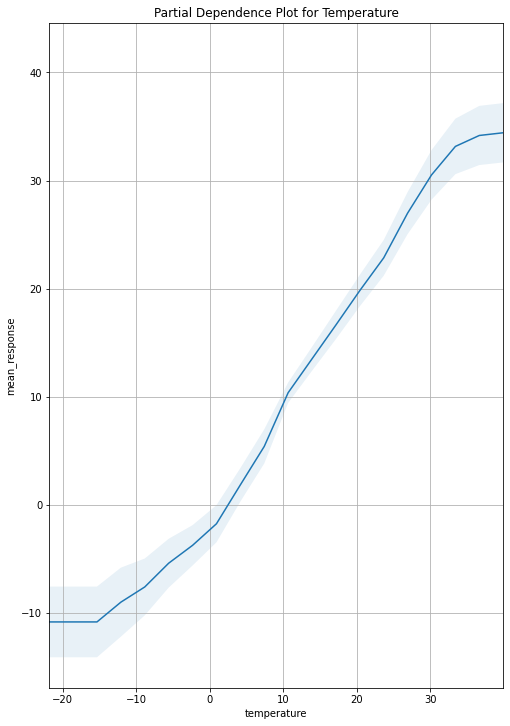

In [51]:
best_model.partial_plot(df, cols=['Temperature'])

##**Regularization using Ridge method in H2O**

In [52]:
weather_glm = H2OGeneralizedLinearEstimator(family = 'gaussian', lambda_ = 0, compute_p_values = True)

In [53]:
weather_glm_regularization = H2OGeneralizedLinearEstimator(family = 'gaussian', lambda_ = 0.1, alpha = 0)

In [54]:
weather_glm.train(x = X, y = y, training_frame = df_train)

glm Model Build progress: |

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: Dropping bad and constant columns: [Formatted_Date, Loud_Cover]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1644802789836_1


GLM Model: summary


family  ... number_of_iterations training_frame
0    gaussian  ...                    1  py_2_sid_8aa5

[1 rows x 8 columns]



ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1.0491780396449746
RMSE: 1.0242939224875713
MAE: 0.8078018756725915
RMSLE: NaN
R^2: 0.9908360334820699
Mean Residual Deviance: 1.0491780396449746
Null degrees of freedom: 77196
Residual degrees of freedom: 76949
Null deviance: 8838246.731696695
Residual deviance: 80993.39712647311
AIC: 223279.5952251178

Scoring History: 


timestamp    duration  ...  training_deviance training_mae training_r2
0    2022-02-14 01:46:34   0.000 sec  ...                                            
1    2022-02-14 01:46:34   0.933 sec  ...           1.049178     0.807802    0.990836

[2 rows x 10 columns]


Variable Importances: 


variable  ...  percentage
0                                                             Temperature  ...    0.039151
1   Daily_Summary.Mostly cloudy until night and breezy starting in the...  ...    0.012974
2   Daily_Summary.Overcast throughout the day and breezy in the aftern...  ...    0.011779
3   Daily_Summary.Partly cloudy starting overnight continuing until ev...  ...    0.011745
4                                                 Summary.Windy and Foggy  ...    0.011668
5                                                  Summary.Breezy and Dry  ...    0.011412
6   Daily_Summary.Mostly cloudy throughout the day and breezy starting...  ...    0.011313
7                             Summary.Dangerously Windy and Partly Cloudy  ...    0.010366
8                                Daily_Summary.Light rain in the morning.  ...    0.010054
9   Daily_Summary.Mostly cloudy starting overnight and breezy starting...  ...    0.009845
10  Daily_Summary.Breezy starting in the morning continuing until afte...  ...    0.009733
11  Daily_Summary.Breezy until afternoon and overcast throughout the day.  ...    0.009338
12  Daily_Summary.Partly cloudy throughout the day and windy starting ...  ...    0.009337
13  Daily_Summary.Mostly cloudy starting in the morning and breezy in ...  ...    0.009126
14  Daily_Summary.Partly cloudy starting in the morning and breezy sta...  ...    0.008945
15  Daily_Summary.Mostly cloudy until evening and breezy starting over...  ...    0.008934
16                                        Summary.Windy and Mostly Cloudy  ...    0.008731
17  Daily_Summary.Partly cloudy throughout the day and breezy in the a...  ...    0.008724
18  Daily_Summary.Partly cloudy starting in the morning continuing unt...  ...    0.008609
19  Daily_Summary.Mostly cloudy until night and breezy starting in the...  ...    0.008308

[20 rows x 4 columns]


See the whole table with table.as_data_frame()


In [55]:
weather_glm_regularization.train(x = X, y = y, training_frame = df_train)

glm Model Build progress: |

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: Dropping bad and constant columns: [Formatted_Date, Loud_Cover]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1644802789836_2


GLM Model: summary


family  ... number_of_iterations training_frame
0    gaussian  ...                    1  py_2_sid_8aa5

[1 rows x 8 columns]



ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 2.5344465902928404
RMSE: 1.5919945321177584
MAE: 1.2863183125632167
RMSLE: NaN
R^2: 0.9778630672609344
Mean Residual Deviance: 2.5344465902928404
Null degrees of freedom: 77196
Residual degrees of freedom: 76946
Null deviance: 8838246.731696695
Residual deviance: 195651.6734308364
AIC: 291370.89956461394

Scoring History: 


timestamp    duration  ...  training_deviance training_mae training_r2
0    2022-02-14 01:46:36   0.000 sec  ...                                            
1    2022-02-14 01:46:36   0.126 sec  ...           2.534447     1.286318    0.977863

[2 rows x 10 columns]


Variable Importances: 


variable  ...  percentage
0                                                             Temperature  ...    0.561993
1                                                        Precip_Type.snow  ...    0.060720
2                                                        Precip_Type.rain  ...    0.057246
3                                                              Wind_Speed  ...    0.052144
4                                                                Humidity  ...    0.046519
5                         Daily_Summary.Partly cloudy throughout the day.  ...    0.017055
6                                                        Summary.Overcast  ...    0.011719
7                                                              Visibility  ...    0.011076
8                                Daily_Summary.Partly cloudy until night.  ...    0.011048
9                                                   Summary.Partly Cloudy  ...    0.008366
10                   Daily_Summary.Partly cloudy starting in the morning.  ...    0.006246
11                        Daily_Summary.Mostly cloudy throughout the day.  ...    0.005904
12  Daily_Summary.Partly cloudy starting in the morning continuing unt...  ...    0.005384
13                                                           Wind_Bearing  ...    0.005350
14                           Daily_Summary.Foggy starting in the evening.  ...    0.004370
15                   Daily_Summary.Mostly cloudy starting in the morning.  ...    0.003946
16                 Daily_Summary.Partly cloudy starting in the afternoon.  ...    0.003790
17  Daily_Summary.Partly cloudy starting overnight continuing until ni...  ...    0.003541
18                                                       Precip_Type.null  ...    0.003473
19       Daily_Summary.Foggy starting overnight continuing until morning.  ...    0.003461

[20 rows x 4 columns]


See the whole table with table.as_data_frame()


In [56]:
coeff_table = weather_glm._model_json['output']['coefficients_table']

In [57]:
coeff_table.as_data_frame()

names  ...  standardized_coefficients
0                                                        Intercept  ...                   9.915982
1                    Daily_Summary.Breezy and foggy until morning.  ...                  -0.539772
2                Daily_Summary.Breezy and mostly cloudy overnight.  ...                  -0.108519
3         Daily_Summary.Breezy and partly cloudy in the afternoon.  ...                   0.553621
4    Daily_Summary.Breezy in the morning and foggy in the evening.  ...                  -0.746498
..                                                             ...  ...                        ...
243                                                       Humidity  ...                   0.132556
244                                                     Wind_Speed  ...                  -0.703798
245                                                   Wind_Bearing  ...                   0.048730
246                                                     Visibility  ...                   0.015960
247                                                       Pressure  ...                   0.009967

[248 rows x 6 columns]

##**Analyzing Data Columns Relationships**

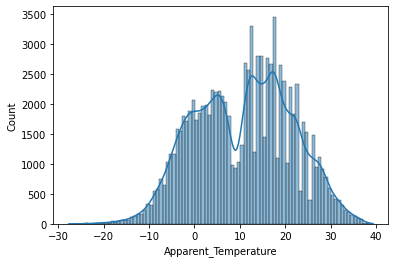

In [58]:
# to check bell curve for normal distrubution
sns.histplot(df1.Apparent_Temperature, kde = True)

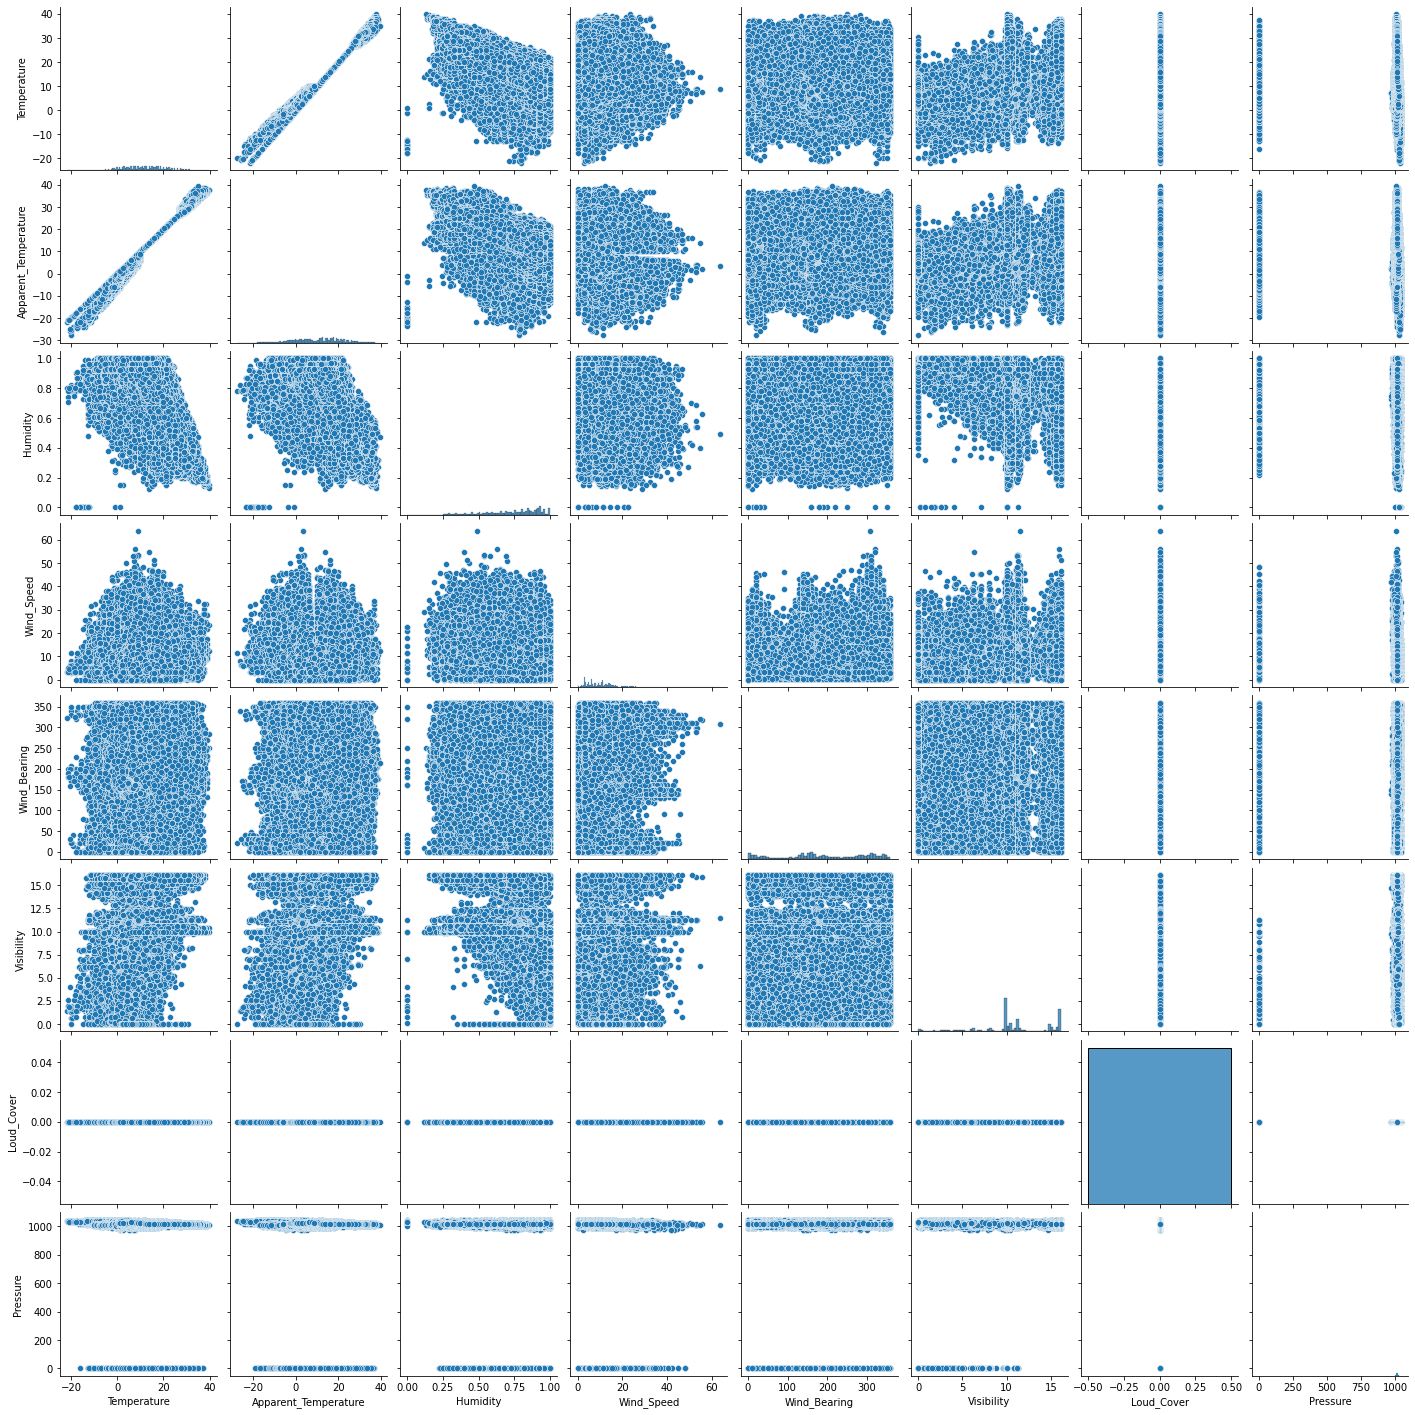

In [59]:
#getting an idea of relation between variables
sns.pairplot(df1)

##**Calculating VIF**

In [60]:
#Calculating VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
Multic = df1[['Humidity', 'Wind_Speed', 'Wind_Bearing', 'Visibility', 'Pressure','Temperature']]

vif = pd.DataFrame()
vif["variables"] = Multic.columns
vif["VIF"] = [variance_inflation_factor(Multic.values, i) for i in range(Multic.shape[1])]
vif

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


variables        VIF
0      Humidity  18.036017
1    Wind_Speed   3.468936
2  Wind_Bearing   4.075435
3    Visibility   8.367566
4      Pressure  33.304352
5   Temperature   3.928052

##**Report Generation**

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id mean_residual_deviance rmse mse mae rmsle training_time_ms predict_time_per_row_ms algo 
 
 
 GBM_1_AutoML_1_20220214_14105 0.0325097 0.180304 0.0325097 0.0989556 nan 14131 0.074417 GBM 
 StackedEnsemble_BestOfFamily_2_AutoML_1_20220214_14105 0.0446174 0.211228 0.0446174 0.129781 nan 1697 0.062297 StackedEnsemble 
 StackedEnsemble_AllModels_1_AutoML_1_20220214_14105 0.044657 0.211322 0.044657 0.130088 nan 1940 0.062522 StackedEnsemble 
 StackedEnsemble_BestOfFamily_1_AutoML_1_20220214_14105 0.0456582 0.213678 0.0456582 0.141289 nan 2231 0.061319 StackedEnsemble 
 DRF_1_AutoML_1_20220214_14105 0.62383 0.789829 0.62383 0.401787 nan 898 0.000798 DRF 
 XGBoost_1_AutoML_1_20220214_14105 0.763183 0.873603 0.763183 0.62273 nan 9057 0.005902 XGBoost 
 GLM_1_AutoML_1_20220214_14105 1.09717 1.04746 1.09717 0.827485 nan 2762 0.0003 GLM 
 XGBoost_2_AutoML_1_20220214_14105 1.24052 1.11379 1.24052 0.833392 nan 1167 0.000946 XGBoost 
 GBM_2_AutoML_1_20220214_14105 6.92931 2.63236 6.92931 2.10592 nan 904 0.004065 GBM 
 GBM_3_AutoML_1_20220214_14105 11.8968 3.44918 11.8968 2.77823 nan 912 0.003564 GBM 
 GBM_4_AutoML_1_20220214_14105 16.4523 4.05615 16.4523 3.32945 nan 941 0.003431 GBM 
 XGBoost_3_AutoML_1_20220214_14105 100.667 10.0333 100.667 8.21877 nan 244 0.000295 XGBoost

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

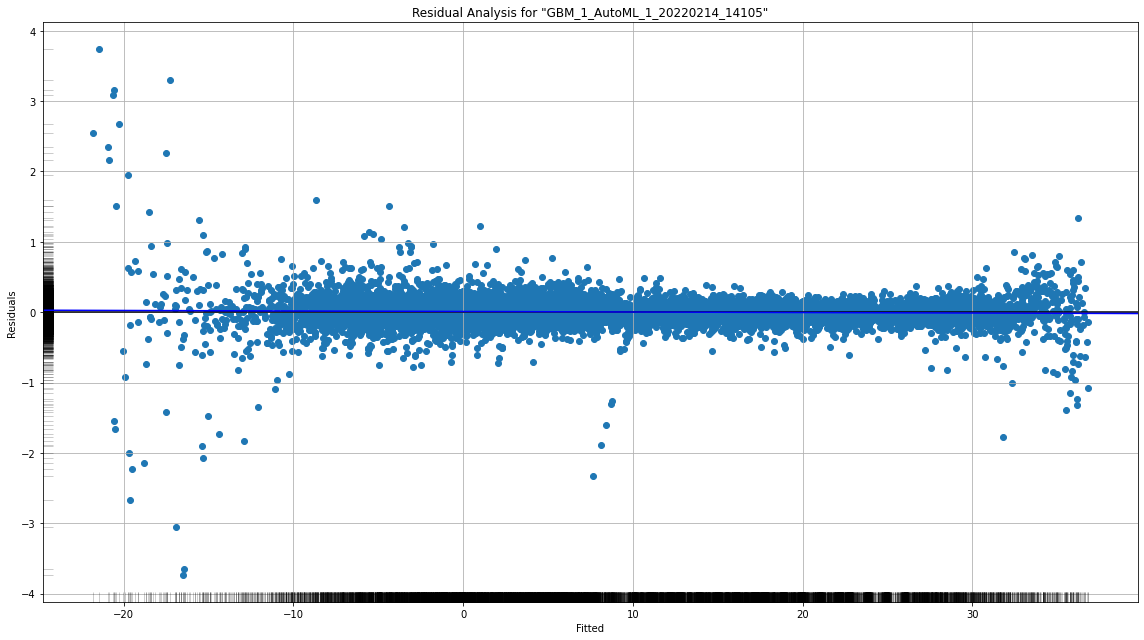

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

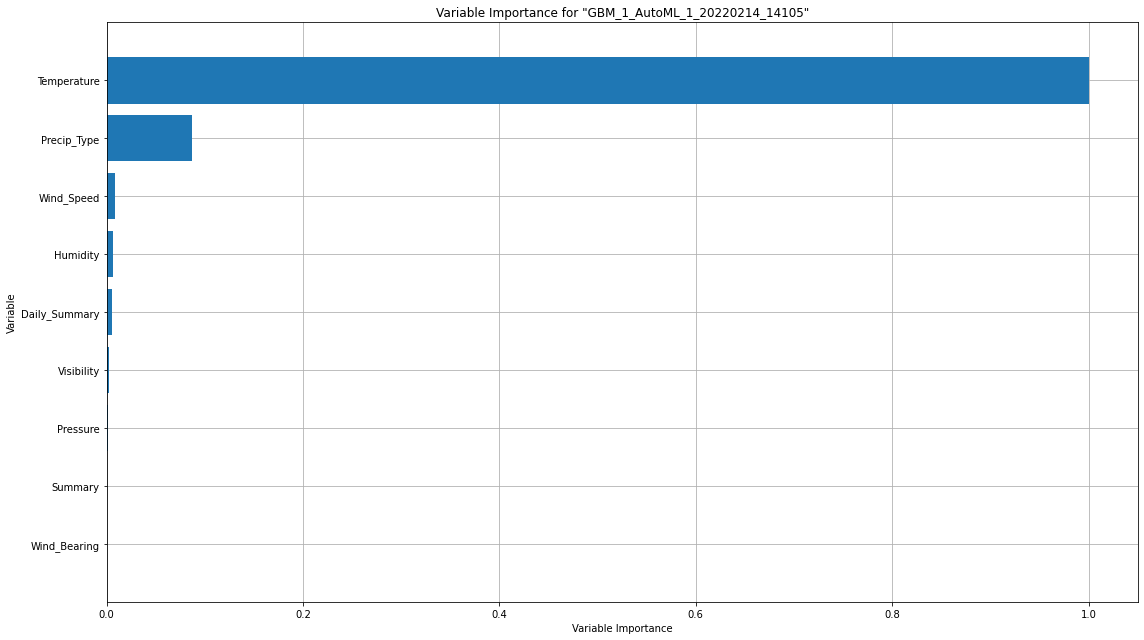

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

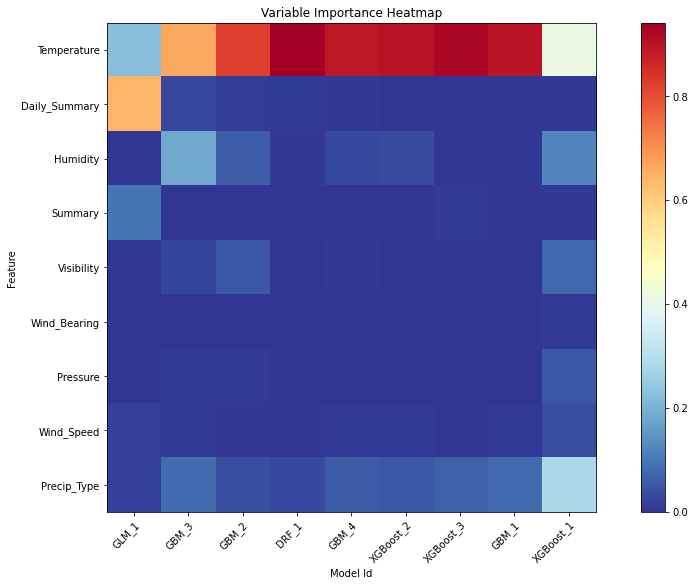

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

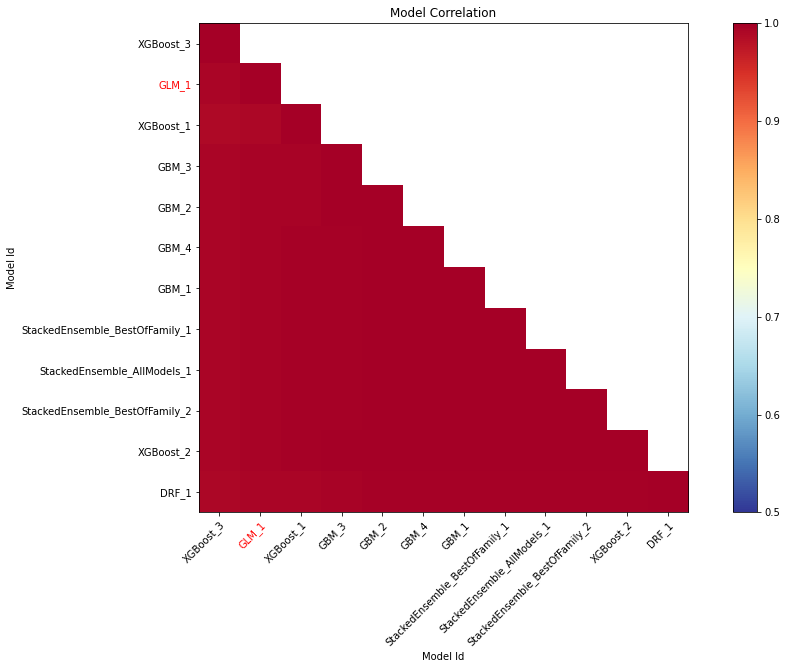

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

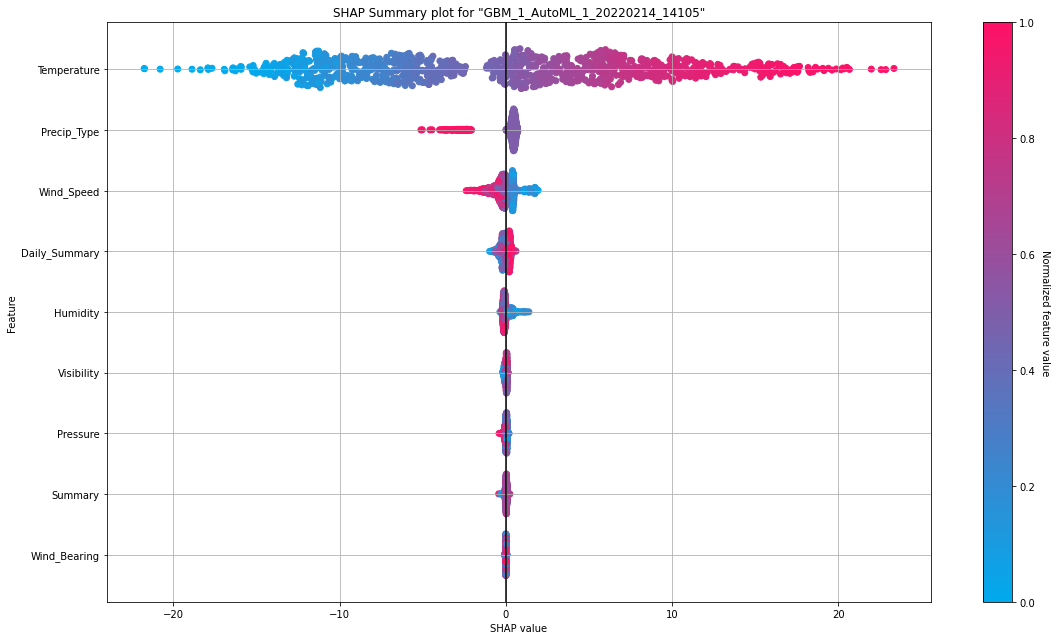

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

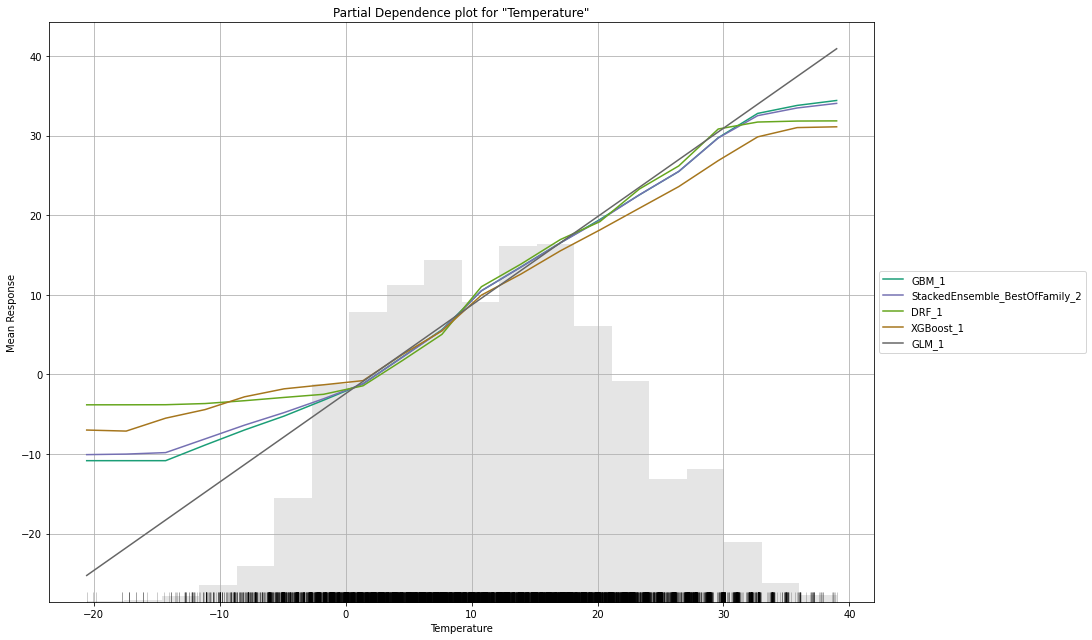

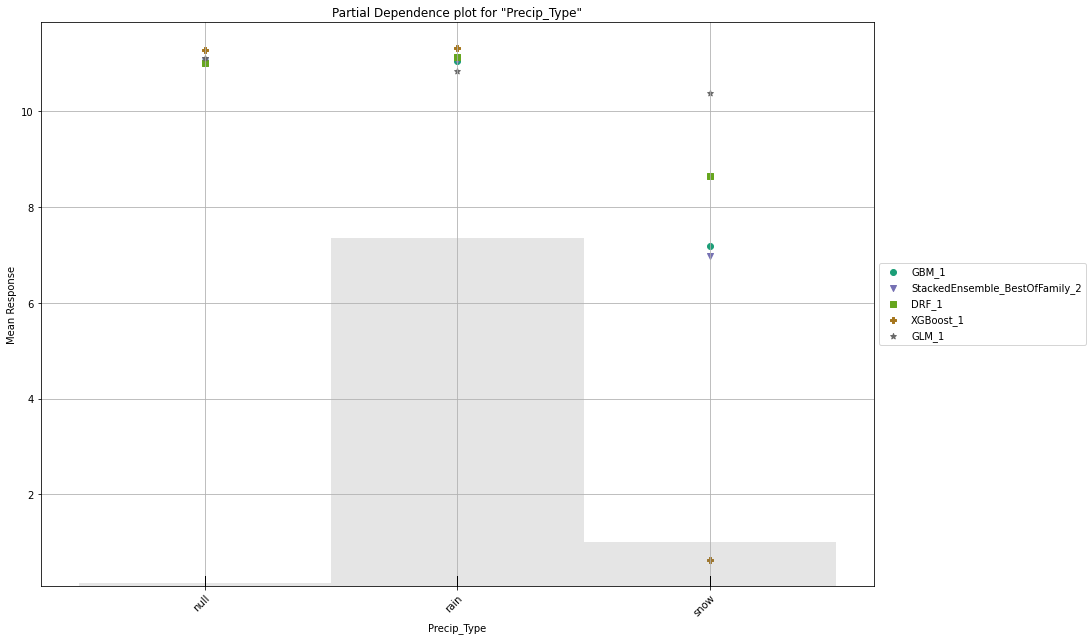

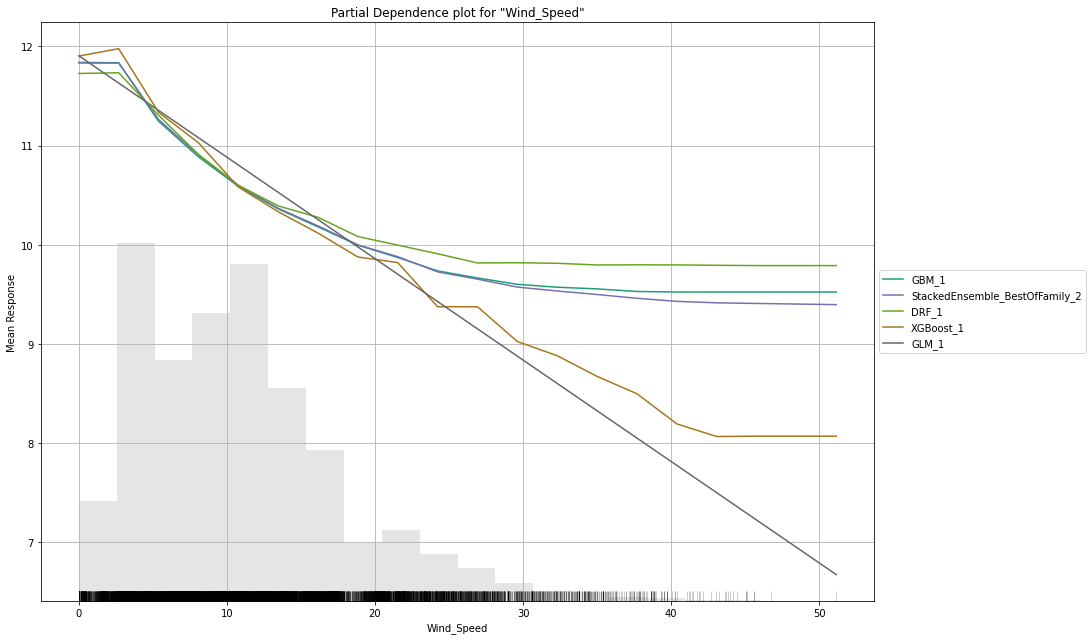

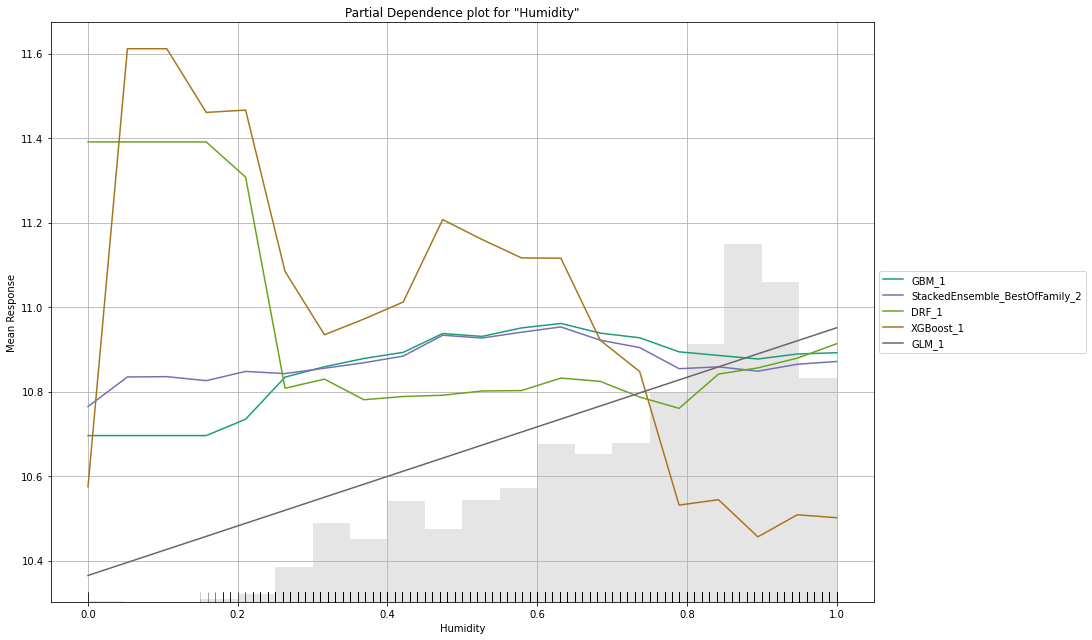

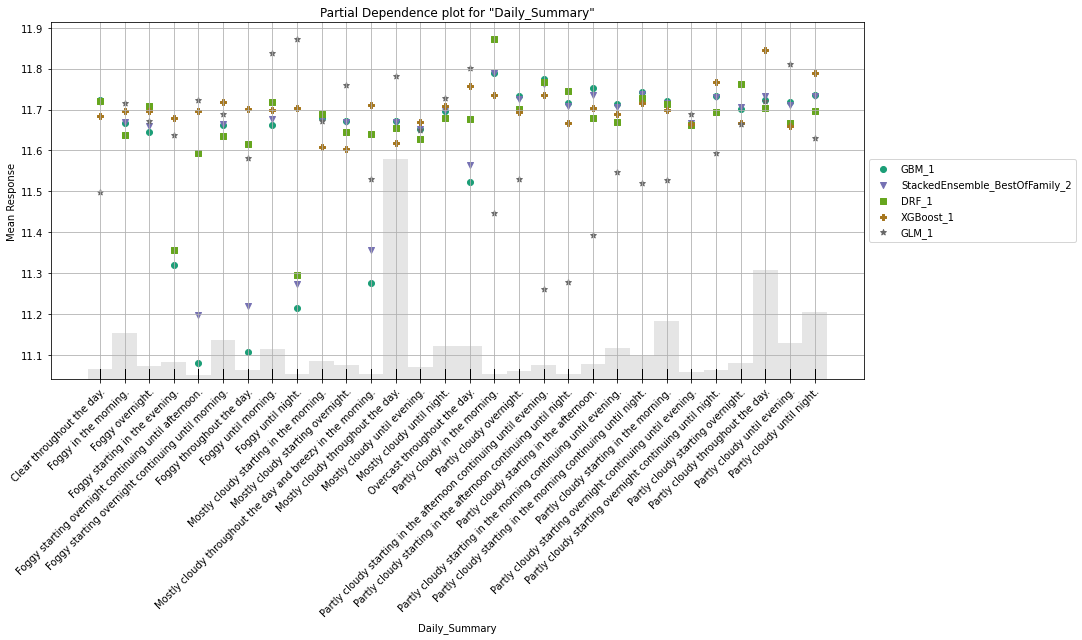

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

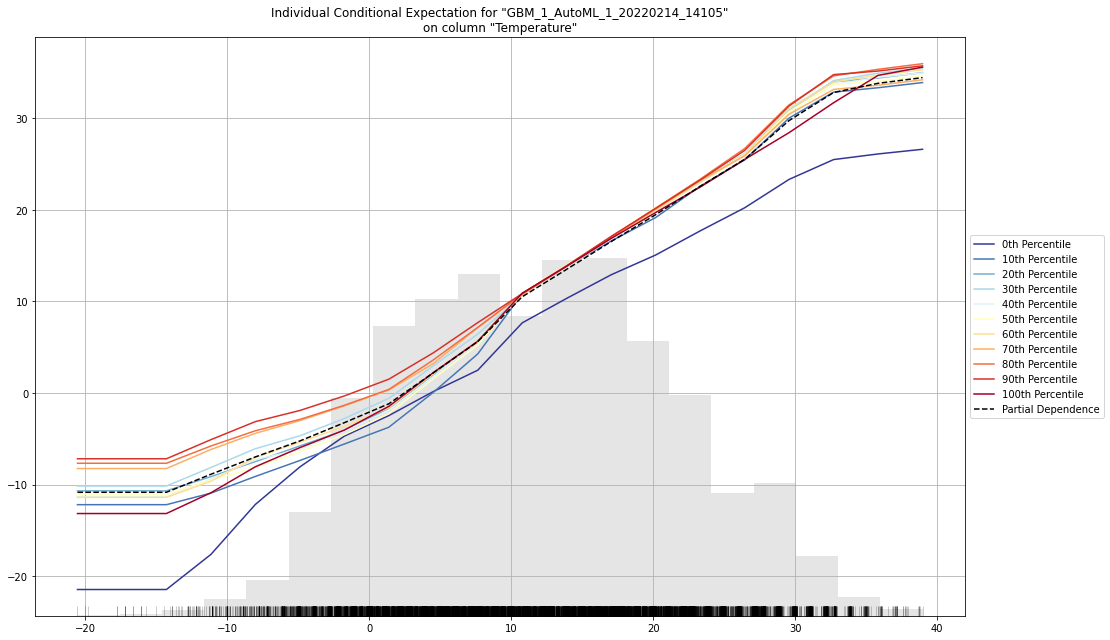

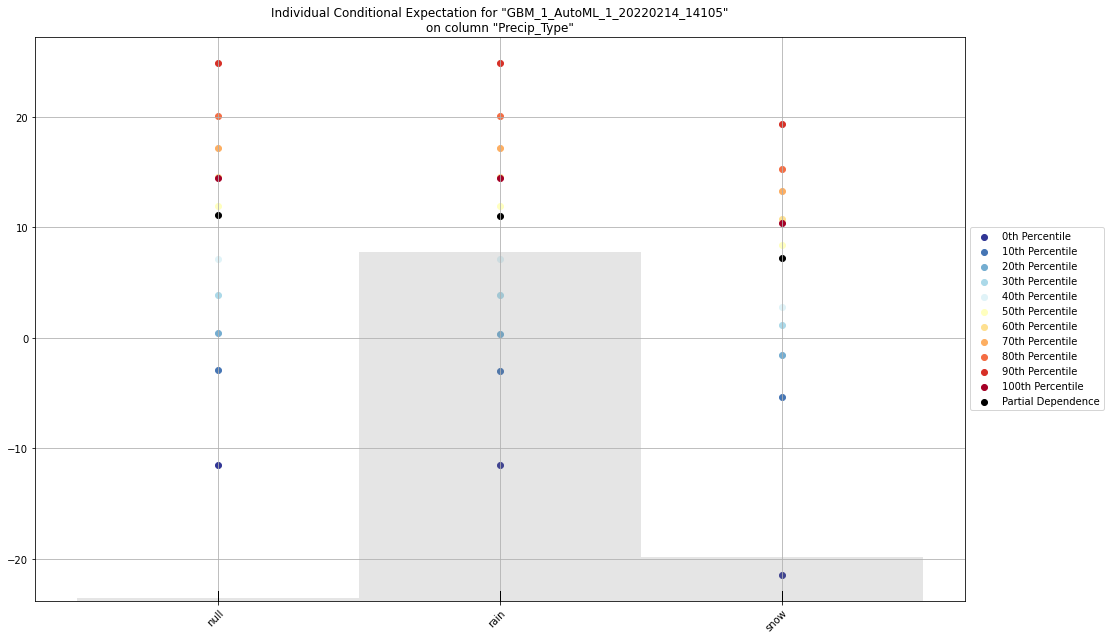

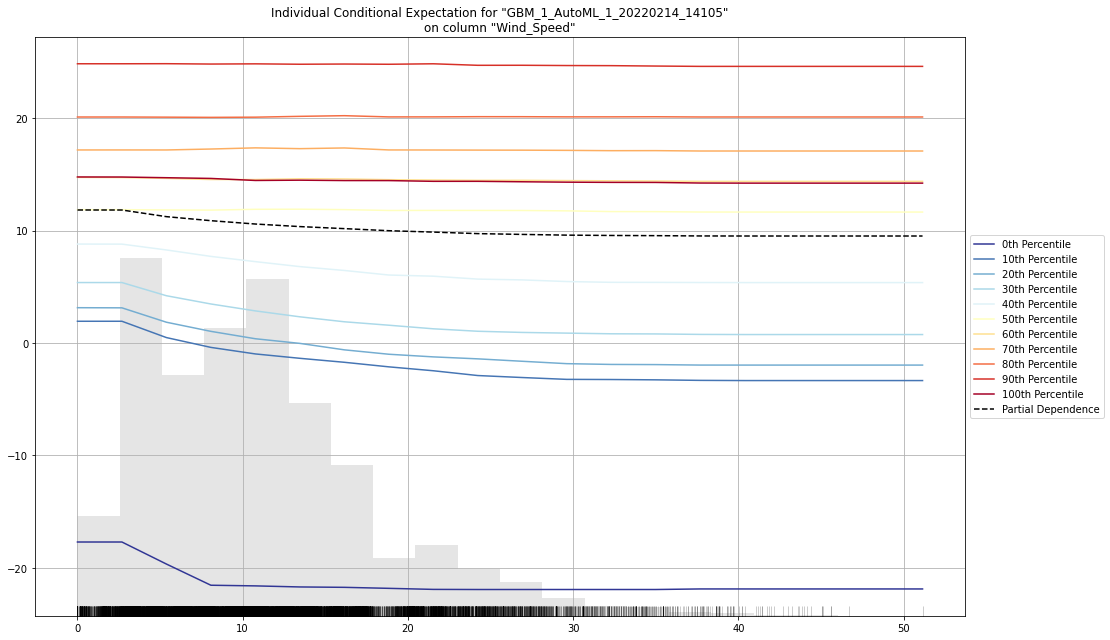

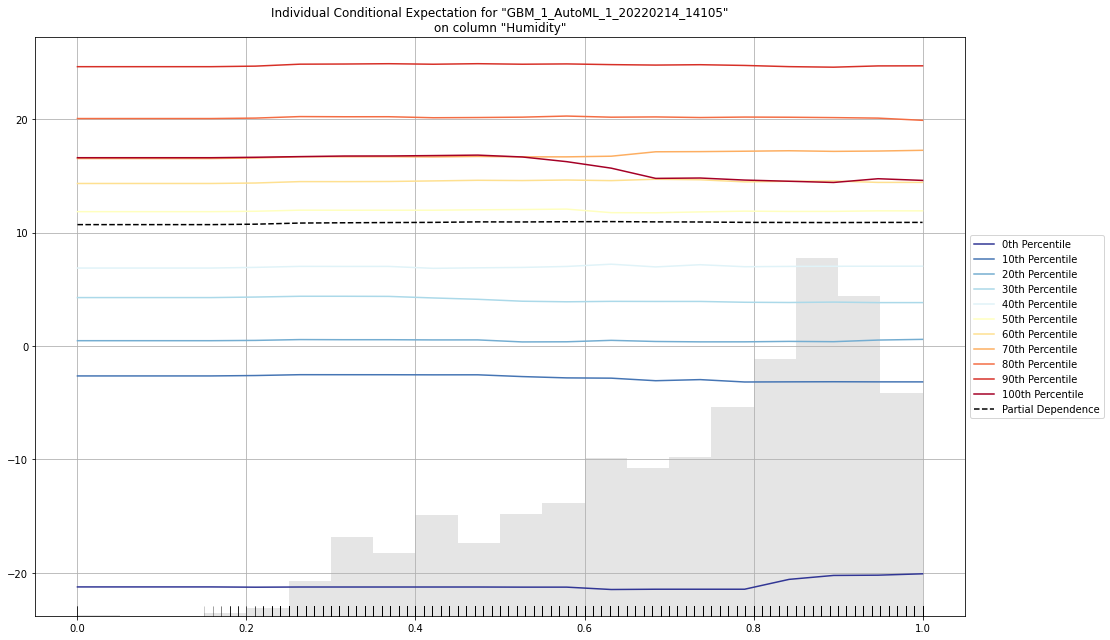

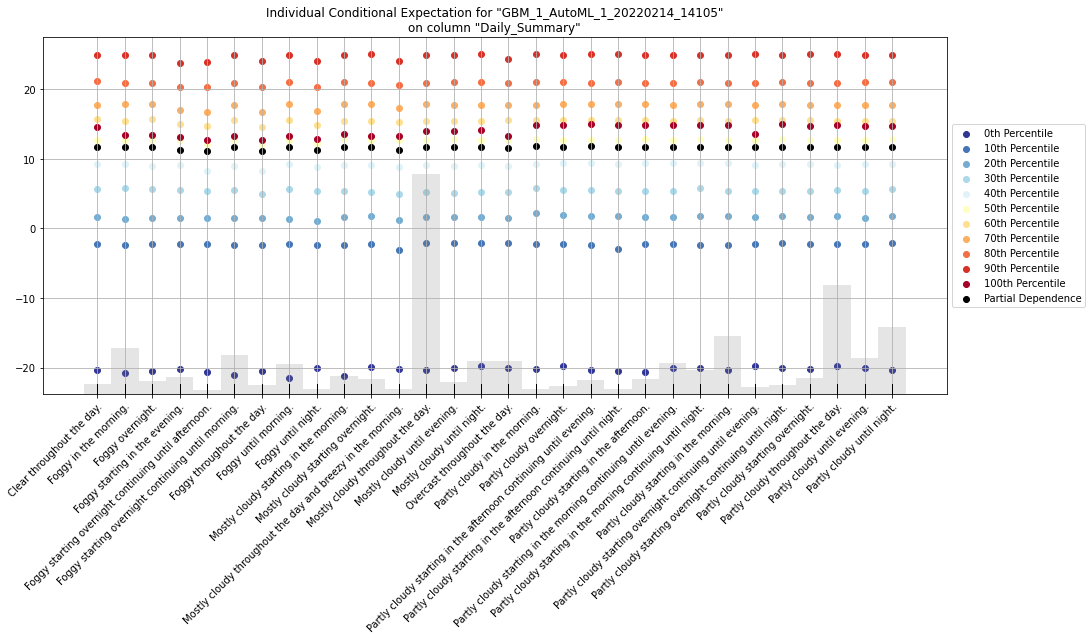

In [61]:
#Generating Detailed Reports
exa = aml.explain(df_test)

##**Residual Calculations**

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
import statsmodels.api as sm
dd = pd.read_csv("/content/drive/MyDrive/DSEM/weatherHistorycopy.csv")

y = dd['Apparent_Temperature']
X = dd.drop(['Apparent_Temperature'], axis = 1)

In [71]:
X_train,X_test,y_train,y_test=tts(X,y,test_size=0.2,random_state=42)

In [72]:
cols1 = ['Temperature','Humidity','Wind_Speed','Wind_Bearing','Visibility','Pressure']
model1 = sm.OLS(y_train,sm.add_constant(X_train[cols1])).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [73]:
y_pred = model1.predict(sm.add_constant(X_train[cols1]))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [74]:
residuals = y_train-y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals 2.292570402746328e-14


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


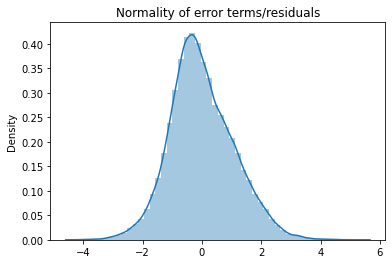

In [75]:

#Plotting the residual values in the graph
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

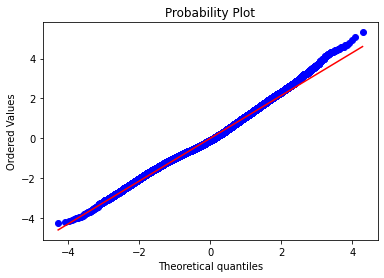

In [76]:

# Plotting qq plot for Residual
import numpy as np 
import pylab 
import scipy.stats as stats

#measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

##**Hyperparameter Tunning**

In [63]:
#Importing library and dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
dd = pd.read_csv("/content/drive/MyDrive/DSEM/weatherHistorycopy.csv")


In [64]:

y = dd['Apparent_Temperature']
X = dd.drop(['Apparent_Temperature'], axis = 1)


In [65]:
#Splitting dataset into train-test datasets
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 101, test_size = 0.2)

In [66]:
#Initializing parameters
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
param_vals = {'max_depth': [200, 500, 800, 1100], 'n_estimators': [100,200, 300, 400], 'min_samples_split' : [2,3,5] }
random_rf = RandomizedSearchCV(estimator=model, param_distributions=param_vals,
                              n_iter=10, scoring='accuracy', cv=5,
                              refit=True, n_jobs=-1)

#Training and prediction

random_rf.fit(X_train, y_train)
preds = random_rf.best_estimator_.predict(X_test)


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning,


In [68]:
#Printing best Parameters
random_rf.best_params_

{'max_depth': 1100, 'min_samples_split': 5, 'n_estimators': 300}

##**P-value Calculation**

In [69]:
#Importing stats stats model and calculating P value, 
import statsmodels.formula.api as smf #OLS model Library

results = smf.ols('Apparent_Temperature ~ Humidity + Wind_Speed + Wind_Bearing + Visibility + Pressure + Temperature ', data=df1).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Apparent_Temperature   R-squared:                       0.990
Model:                              OLS   Adj. R-squared:                  0.990
Method:                   Least Squares   F-statistic:                 1.567e+06
Date:                  Mon, 14 Feb 2022   Prob (F-statistic):               0.00
Time:                          02:50:19   Log-Likelihood:            -1.4410e+05
No. Observations:                 96453   AIC:                         2.882e+05
Df Residuals:                     96446   BIC:                         2.883e+05
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.5925      0.040    -65.075      0.000      -2.671      -2.514
Humidity         1.0318      0.024     42.630      0.000       0.984       1.079
Wind_Speed      -0.0957      0.001   -180.960      0.000      -0.097      -0.095
Wind_Bearing     0.0005   3.26e-05     16.309      0.000       0.000       0.001
Visibility      -0.0008      0.001     -0.888      0.375      -0.003       0.001
Pressure         0.0002   2.98e-05      6.718      0.000       0.000       0.000
Temperature      1.1256      0.000   2295.962      0.000       1.125       1.127
==============================================================================
Omnibus:                     1801.186   Durbin-Watson:                   0.431
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1989.488
Skew:                           0.308   Prob(JB):                         0.00
Kurtosis:                       3.339   Cond. No.                     1.27e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##**Conclusion**

In this H2O AutoML assigment, I have successfully executed my dataset in H2O AutoML framework.

Moreover, I have learned and performed various ML operations like Feature Engineering, Data Vizualization, trained and tested data on best model with the help of H2O and sklearn.

**Some noteworthy conclusions-**

**Model Comparison -** 

1. The best model accuracy RSquare value is 0.99. and also the RSME, MAE and RSE values are very low.
2. The GBM model worked pretty well for the regression dataset with good accuracy.


**Feature Engineering-**

1. For binnary data we mapped data to 0 and 1 acoordingly.
2. For ordinal data according to the order number was assigned to each category in the variable.


Apart from H2O AutoML execution,

1. I have successfully calculated the best parameters using hyperparameters tunning.

2. Also, I have performed the regularization and concluded that it did not help me to increase the accuracy.

3. Analyze and plotted the dataset using seaborn and pandas library to find the relationships and correlation between and columns.

##**Reference/Citations**


H2O AutoML link - https://github.com/nikbearbrown/AI_Research_Group/blob/main/Kaggle_Datasets/AutoML/VAI_Churn_H2O_automl.ipynb

H2O AutoML Model - https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

H2O AutoMl Model Explain - https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html

Hyperparameter tunning - 
https://towardsdatascience.com/hyperparameter-tuning-in-python-21a76794a1f7


Regularization - https://www.nbshare.io/notebook/391169912/Lasso-and-Ridge-Linear-Regression-Regularization/

Dataset - https://www.kaggle.com/rahulk29/perdicting-temperature-using-linear-regression/data



##**Questions/Answers**

1. Is the relationship significant?

Answer - The p-values of the columns in the dataset is less than 0.05 and hence the relationship is significant. If p-value is less than 0.05, it rejects the null hypothesis.
Null hypothesis means type of hypothesis in statistics that proposes that there is no difference between certain characteristics of a population (or data-generating process).

2. Are any model assumptions violated?

Answer - For this dataset, there is colinearity between Temprature and Actual Temprature columns, also there is very less or no colinearity between the other columns.

The Durbin Watson (DW) statistic is a test for autocorrelation in the residuals from a statistical model or regression analysis. The Durbin-Watson statistic will always have a value ranging between 0 and 4. A value of 2.0 indicates there is no autocorrelation detected in the sample. Values from 0 to less than 2 point to positive autocorrelation and values from 2 to 4 means negative autocorrelation.
The Durbin Watson value is 0.46 which states the positive auto correlation in the sample.
Homoscedasticity which means normality of the error distribution - The plot for residuals should be normally distributed i.e., it should form a bell-curve shape. For this model, we have achieved.
Hence, there is no model asumption violated.

3. Is there any multicollinearity in the model?

Answer - 
According to the correaltion table and correlation plot between two columns, no correlation value is near to 1. Hence, we can say that there is no multi-colinearity in the model.

4. In the multivariate models are predictor variables independent of all the other predictor variables?

Answer - 
A multivariate model is a statistical tool that uses multiple variables to forecast outcomes.
In my dataset and according to the correaltion plot and table, all the predictor variables are independent of the other predictor variables.

5. In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

Answer - The most significant variables are - Temprature, Precp_type, Wind Speed, Humidity.

6. Does the model make sense?

Answer - The RSME, MSE and MAE values are very less and also the R_square value is 0.99. Yes, the model makes sense for this dataset as the the performance is good. As the R_square value is optimum there is no need to implement anything to improve the performance.

7. Does regularization help?

Answer - 
Regularizations is technique used to reduce the error by fitting a function appropriately on the given training set and avoid overfitting.
I have applied Ridge method to perform the regularization. Before and after Regularization, the errors - RSME, MSE and MAE are same for the training dataset.
Hence, regularization does not help for this model.

8. Which independent variables are significant?

Answer - 
An independent variable is exactly what it sounds like. It is a variable that stands alone and isn't changed by the other variables you are trying to measure.

In Regression, the variables who's p-value is less than 0.05 and close to 0 is regarded as the the significant variables.
In this dataset, all the the variables are less than 0.05 and hence all those are significant.

9. Which hyperparameters are important?

Answer - 
In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process.

For this assigment, I have performed the Hyperparameter tunning using RandomForestRegressor. The best hyperparaters which I got are as follows - 
{'max_depth': 500, 'min_samples_split': 2, 'n_estimators': 100}

##**License**

**Copyright> (Year:-2022) Name: Tejas Bawankar**

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.